In [119]:
# try
import sys

import pandas as pd # type: ignore
import numpy as np # type: ignore

import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

import networkx as nx # type: ignore
import graphviz # type: ignore

import statsmodels.formula.api as smf # type: ignore
from sklearn.neighbors import NearestNeighbors

from dowhy import CausalModel, gcm # type: ignore

from sklearn.neighbors import NearestNeighbors # type: ignore


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [120]:
def check_for_dataset_balance(control_idx, treatment_idx, estimate_type):

    if estimate_type == 'att':
        control_df = control.iloc[control_idx][covariates]
        treatment_df = treated.loc[treatment_idx][covariates]
        control_df['is_treatment'] = 0
        treatment_df['is_treatment'] = 1
        matched_df = pd.concat([control_df, treatment_df])
        return matched_df.groupby('is_treatment').describe().T
    elif estimate_type == 'atc':
        control_df = control.loc[control_idx][covariates]
        treatment_df = treated.iloc[treatment_idx][covariates]
        control_df['is_treatment'] = 0
        treatment_df['is_treatment'] = 1
        matched_df = pd.concat([control_df, treatment_df])
        return matched_df.groupby('is_treatment').describe().T
        

In [121]:
df = pd.read_csv("../data/processed/data.csv")
df.shape

In [122]:
nodes_list = [
'Rating',
'product_category_name_encoded',
'freight_value',
'distance_km',
'month',
'is_delivery_late'
]

df[nodes_list].isnull().sum()

Rating                           0
product_category_name_encoded    0
freight_value                    0
distance_km                      0
month                            0
is_delivery_late                 0
dtype: int64

# Potential Outcomes: Effect of Delayed Delieveries on Ratings

In [123]:
# Define covariates, treatment, and outcome
covariates = ['product_category_name_encoded', 'month', 'product_size', 'freight_value', 'distance_km']
treatment = 'is_delivery_late'
outcome = 'Rating'

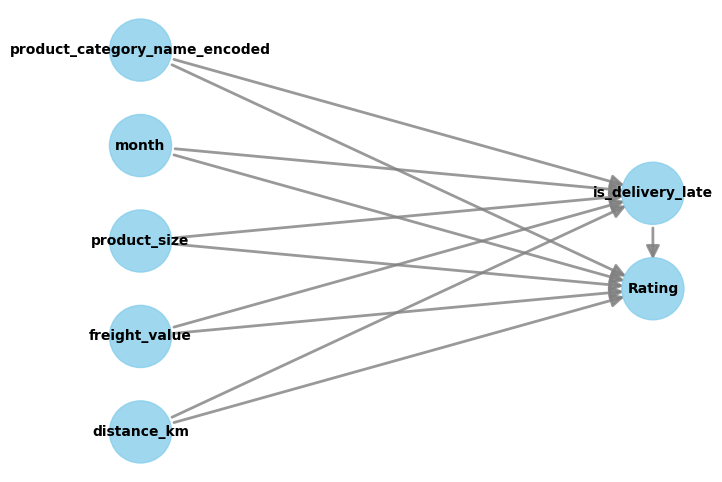

In [124]:
# Step 1: Build the causal model
# We specify the treatment, outcome, and confounders in the model.
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=covariates
)

# Step 2: View the graphical model (optional)
# This visualizes the causal structure and how variables are related.
model.view_model()

In [125]:
# Step 3: Identify the causal effect
# Specify how to estimate the causal effect. Here we use matching with propensity scores.
identified_estimand = model.identify_effect()

In [126]:
# Step 4: Estimate the treatment effect using propensity score matching
# This will estimate the causal effect using Propensity Score Matching (PSM).
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="ate"
)

**Estimating ATT**

In [128]:
treated = df.loc[df['is_delivery_late'] == 1]
control = df.loc[df['is_delivery_late'] == 0]

control_neighbors = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(
    control['propensity_score'].values.reshape(-1, 1)
)
distances, indices = control_neighbors.kneighbors(treated['propensity_score'].values.reshape(-1, 1))

att = 0
outcome_variable = 'Rating'
treated_outcomes = treated[outcome_variable]
control_outcomes = list(control.iloc[indices.flatten()][outcome_variable])

att = (treated_outcomes - control_outcomes).mean()
print("att: ", att)

att:  -1.9841205211726385


**Checking for Balancing in the matched dataset**

In [140]:
balance = check_for_dataset_balance(control_idx=indices.flatten() , treatment_idx=treated.index, estimate_type='att')
balance

is_treatment                                     0              1
product_category_name_encoded count    7368.000000    7368.000000
                              mean       36.361971      35.826547
                              std        21.870491      22.143118
                              min         0.000000       0.000000
                              25%        13.000000      13.000000
                              50%        32.000000      32.000000
                              75%        54.000000      54.000000
                              max        72.000000      72.000000
month                         count    7368.000000    7368.000000
                              mean        5.761944       5.672503
                              std         3.202594       3.622336
                              min         1.000000       1.000000
                              25%         3.000000       3.000000
                              50%         6.000000       4.000000
                              75%         8.000000       9.000000
                              max        12.000000      12.000000
product_size                  count    7368.000000    7368.000000
                              mean    18601.306460   17149.686346
                              std     28906.140162   26811.490004
                              min       352.000000     352.000000
                              25%      3080.000000    2880.000000
                              50%      7854.000000    6912.000000
                              75%     21840.000000   19800.000000
                              max    277550.000000  269500.000000
freight_value                 count    7368.000000    7368.000000
                              mean       22.636634      22.725935
                              std        19.315028      18.482168
                              min         0.000000       0.000000
                              25%        14.100000      15.050000
                              50%        17.670000      17.670000
                              75%        24.590000      23.370000
                              max       314.400000     237.110000
distance_km                   count    7368.000000    7368.000000
                              mean      744.493366     761.909998
                              std       700.111720     690.015157
                              min         0.121756       0.000000
                              25%       267.437685     311.915335
                              50%       507.528757     529.770385
                              75%       971.114988     960.225156
                              max      3399.190906    8677.911622

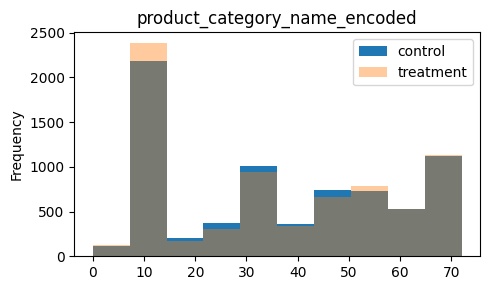

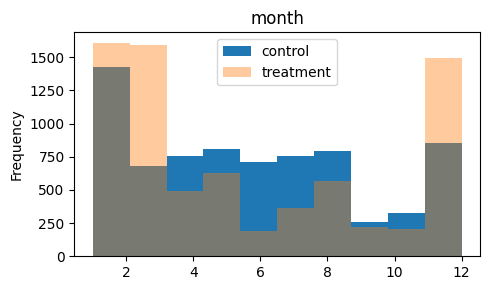

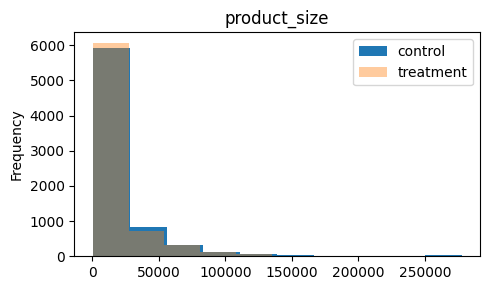

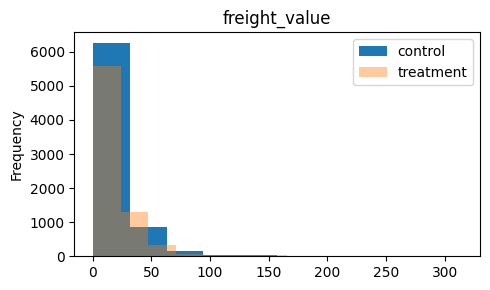

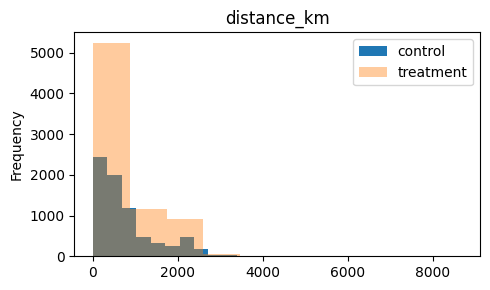

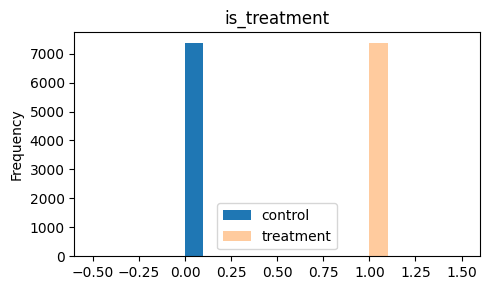

In [141]:
control_df = control.iloc[indices.flatten()][covariates]
treatment_df = treated.loc[treated.index][covariates]
control_df['is_treatment'] = 0
treatment_df['is_treatment'] = 1
matched_df = pd.concat([control_df, treatment_df])

for col in matched_df.columns:
    plt.figure(figsize=(5,3))
    matched_df[matched_df['is_treatment'] == 0][col].plot(kind='hist', label='control')
    matched_df[matched_df['is_treatment'] == 1][col].plot(kind='hist', alpha=0.4, label='treatment')
    plt.title(col)
    plt.legend()
    plt.tight_layout()
    plt.show()

**Estimating ATC**

In [115]:
# Estimating ATC
treated = df.loc[df['is_delivery_late'] == 1]
control = df.loc[df['is_delivery_late'] == 0]

treated_neighbors = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(
    treated['propensity_score'].values.reshape(-1, 1)
)
distances, indices = treated_neighbors.kneighbors(control['propensity_score'].values.reshape(-1, 1))

atc = 0
outcome_variable = 'Rating'
control_outcomes = control[outcome_variable]
treated_outcomes = list(treated.iloc[indices.flatten()][outcome_variable])

atc = (treated_outcomes - control_outcomes).mean()

print("ATC: ", atc)

ATC:  -1.8957784745936188


In [117]:
balance = check_for_dataset_balance(control_idx=control.index, treatment_idx=indices.flatten(), estimate_type='atc')
balance

is_treatment                                     0              1
product_category_name_encoded count  107473.000000  107473.000000
                              mean       36.742680      36.272441
                              std        22.108333      22.342795
                              min         0.000000       0.000000
                              25%        13.000000      13.000000
                              50%        32.000000      32.000000
                              75%        55.000000      57.000000
                              max        72.000000      72.000000
month                         count  107473.000000  107473.000000
                              mean        6.057159       6.070306
                              std         3.197965       3.641375
                              min         1.000000       1.000000
                              25%         3.000000       3.000000
                              50%         6.000000       5.000000
                              75%         8.000000      10.000000
                              max        12.000000      12.000000
product_size                  count  107473.000000  107473.000000
                              mean    15144.000540   14191.509709
                              std     23144.479808   21708.288747
                              min       168.000000     352.000000
                              25%      2856.000000    2808.000000
                              50%      6552.000000    5832.000000
                              75%     18150.000000   16555.000000
                              max    296208.000000  269500.000000
freight_value                 count  107473.000000  107473.000000
                              mean       19.786251      20.796544
                              std        15.478152      16.696433
                              min         0.000000       0.000000
                              25%        12.930000      14.100000
                              50%        16.180000      16.790000
                              75%        21.040000      21.300000
                              max       409.680000     237.110000
distance_km                   count  107473.000000  107473.000000
                              mean      583.718524     611.013846
                              std       577.414843     578.720465
                              min         0.000000       0.000000
                              25%       176.547201     260.603570
                              50%       424.496622     447.622593
                              75%       776.605751     775.433041
                              max      5338.619521    3927.406027

**Estimating ATE**

In [118]:
numtreatedunits = treated.shape[0]
numcontrolunits = control.shape[0]
est = (att * numtreatedunits + atc * numcontrolunits) / (numtreatedunits + numcontrolunits)
print("ATE: ", est)

ATE:  -1.9014463475587986


ATE (Average Treatment Effect)

In [24]:
# Step 5: View the results
# This will show the average treatment effect (ATE) of late deliveries on review scores.
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                     ↪
───────────────────(E[Rating|product_category_name_encoded,product_size,month, ↪
d[is_delivery_late]                                                            ↪

↪                            
↪ freight_value,distance_km])
↪                            
Estimand assumption 1, Unconfoundedness: If U→{is_delivery_late} and U→Rating then P(Rating|is_delivery_late,product_category_name_encoded,product_size,month,freight_value,distance_km,U) = P(Rating|is_delivery_late,product_category_name_encoded,product_size,month,freight_value,distance_km)

## Realized estimand
b: Rating~is_delivery_late+product_category_name_encoded+product_size+month+freight_value+distance_km
Target units: ate

## Estimate
Mean value: -1.9014463475587986



Boostrap Confidence Interval

In [ ]:
# Estimate the treatment effect using Propensity Score Matching (PSM)
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)

# Display the causal estimate, confidence intervals, and standard error
print("Causal Estimate (ATE):", estimate.value)
print("Confidence Interval:", estimate.get_confidence_intervals())
print("Standard Error:", estimate.get_standard_error())

Sensitivity Analysis: Unobserved Confounder

In [ ]:
# Add an unobserved confounder and see how the treatment effect changes
refutation_unobserved_confounding = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="add_unobserved_common_cause"
)

# Display the refutation results
print(refutation_unobserved_confounding)

ATT (Average Treatment Effect on Treated)

In [ ]:
# Estimate ATT using DoWhy
estimate_ATT = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="att"  # Specify that we are interested in the ATT (treated units)
)

# Display the ATT
print("ATT (Average Treatment effect on the Treated):", estimate_ATT.value)


ATC (Average Treatment Effect on Control)

In [ ]:
# Estimate ATC using DoWhy
estimate_ATC = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="atc"  # Specify that we are interested in the ATC (control units)
)

# Display the ATC
print("ATC (Average Treatment effect on the Controls):", estimate_ATC.value)

# Bootstrap Propensity Score Matching

**Bootstrap Propensity Score Matching**

In [156]:
number_of_bootstraps = 300
number_of_samples = 10000
atc_lst = []

for i in range(number_of_bootstraps):

    df_sample = df.sample(n=number_of_samples)
    treated = df_sample.loc[df['is_delivery_late'] == 1]
    control = df_sample.loc[df['is_delivery_late'] == 0]

    treated_neighbors = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(
        treated['propensity_score'].values.reshape(-1, 1)
    )
    distances, indices = treated_neighbors.kneighbors(control['propensity_score'].values.reshape(-1, 1))

    atc = 0
    outcome_variable = 'Rating'
    control_outcomes = control[outcome_variable]
    treated_outcomes = list(treated.iloc[indices.flatten()][outcome_variable])

    atc = (treated_outcomes - control_outcomes).mean()
    atc_lst.append(atc)
    

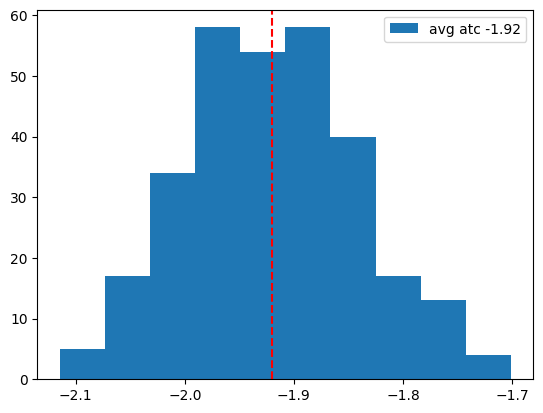

In [160]:
plt.hist(atc_lst, label=f'avg atc {round(np.mean(atc_lst),2)}')
plt.axvline(np.mean(atc_lst), ls='--', c='red')
plt.legend();

-----

**Resources:**


- Bootstrap Propensity Score Matching: https://arxiv.org/html/2408.05297v1


